# Decision Tree Project 1: the `iris` dataset

We are going to use the Decision Tree model to study the `iris` dataset. This dataset has already studied previously using k-NN. Again we will only use the first two features for visualization purpose.

## Initial setup

Since the dataset will be splitted, we will put `X` and `y` together as a single variable `S`. In this case when we split the dataset by selecting rows, the features and the labels are still paired correctly. 

We also print the labels and the feature names for our convenience.

In [1]:
from sklearn.datasets import load_iris
import numpy as np
from assests.codes.dt import gini, split, countlabels

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target
y = y.reshape((y.shape[0],1))
S = np.concatenate([X,y], axis=1)

print(iris.target_names)
print(iris.feature_names)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


## Apply CART manually

We apply `split` to the dataset `S`. 

In [2]:
r = split(S)
if r['split'] is True:
    Gl, Gr = r['sets']
    print(r['pair'])
    print('The left subset\'s Gini impurity is {g:.2f},'.format(g=gini(Gl)),
          ' and its label counts is {d:}'.format(d=countlabels(Gl)))
    print('The right subset\'s Gini impurity is {g:.2f},'.format(g=gini(Gr)),
          ' and its label counts is {d}'.format(d=countlabels(Gr)))

(0, 1.9)
The left subset's Gini impurity is 0.00,  and its label counts is {0.0: 50}
The right subset's Gini impurity is 0.50,  and its label counts is {1.0: 50, 2.0: 50}


The results shows that `S` is splitted into two subsets based on the `0`-th feature and the split value is `1.9`. 

The left subset is already pure since its Gini impurity is `0`. All elements in the left subset is label `0` (which is `setosa`). The right one is mixed since its Gini impurity is `0.5`. Therefore we need to apply `split` again to the right subset.

In [3]:
r = split(Gr)
if r['split'] is True:
    Grl, Grr = r['sets']
    print(r['pair'])
    print('The left subset\'s Gini impurity is {g:.2f},'.format(g=gini(Grl)),
          ' and its label counts is {d:}'.format(d=countlabels(Grl)))
    print('The right subset\'s Gini impurity is {g:.2f},'.format(g=gini(Grr)),
          ' and its label counts is {d}'.format(d=countlabels(Grr)))

(1, 1.7)
The left subset's Gini impurity is 0.17,  and its label counts is {1.0: 49, 2.0: 5}
The right subset's Gini impurity is 0.04,  and its label counts is {2.0: 45, 1.0: 1}


This time the subset is splitted into two more subsets based on the `1`-st feature and the split value is `1.7`. The total Gini impurity is minimized using this split. 

The decision we created so far can be described as follows:

1. Check the first feature `sepal length (cm)` to see whether it is smaller or equal to `1.9`.
   1. If it is, classify it as lable `0` which is `setosa`.
   2. If not, continue to the next stage.
2. Check the second feature `sepal width (cm)` to see whether it is smaller or equal to `1.7`. 
   1. If it is, classify it as label `1` which is `versicolor`.
   2. If not, classify it as label `2` which is `virginica`.

## Use package `sklearn`

Now we would like to use the decision tree package provided by `sklearn`. The process is straightforward. The parameter `random_state=40` will be discussed {ref}`later<note-random_state>`, and it is not necessary in most cases.

In [4]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=40)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

`sklearn` provide a way to automatically generate the tree view of the decision tree. The code is as follows. 

[Text(0.4, 0.8333333333333334, 'X[1] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.6, 0.5, 'X[1] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.043\nsamples = 46\nvalue = [0, 1, 45]')]

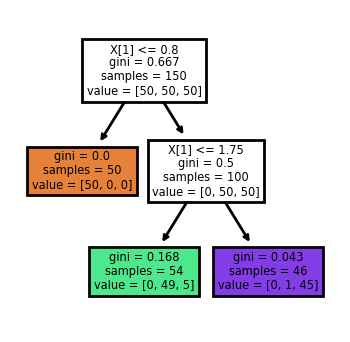

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2, 2), dpi=200)
tree.plot_tree(clf, filled=True, impurity=True)

Similar to k-NN, we may use `sklearn.inspection.DecisionBoundaryDisplay` to visualize the decision boundary of this decision tree.

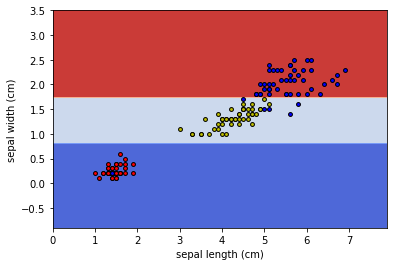

In [6]:
from sklearn.inspection import DecisionBoundaryDisplay
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap='coolwarm',
    response_method="predict",
    xlabel=iris.feature_names[0],
    ylabel=iris.feature_names[1],
)

# Plot the training points
for i, color in zip(range(3), 'ryb'):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        c=color,
        label=iris.target_names[i],
        cmap='ryb',
        edgecolor="black",
        s=15,
        )

## Analyze the differences between the two methods
The tree generated by `sklearn` and the tree we got manually is a little bit different. Let us explore the differences here. 

To make it easier to split the set, we could convert the `numpy.ndarray` to `pandas.DataFrame`.

In [8]:
import pandas as pd

df = pd.DataFrame(X)
df.head()

,0,1
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


Now based on our tree, we would like to get all data points that the first feature (which is marked as `0`) is smaller or equal to `1.9`. We save it as `df1`. Similarly based on the tree gotten from `sklearn`, we would like to get all data points taht the second feature (which is marked as `1`) is smaller or equal to `0.8` and save it to `df2`. 

In [51]:
df1 = df[df[0]<=1.9]
df2 = df[df[1]<=0.8]

Then we would like to compare these two dataframes. What we want is to see whether they are the same regardless the order. One way to do this is to sort the two dataframes and then compare them directly.

To sort the dataframe we use the method `DataFrame.sort_values`. The details can be found [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html). Note that after `sort_values` we apply `reset_index` to reset the index just in case the index is massed by the sort operation.

Then we use `DataFrame.equals` to check whether they are the same.

In [52]:
df1sorted = df1.sort_values(by=df1.columns.tolist()).reset_index(drop=True)
df2sorted = df2.sort_values(by=df2.columns.tolist()).reset_index(drop=True)
print(df1sorted.equals(df2sorted))

True


So these two sets are really the same. The reason this happens can be seen from the following two graphs.


::::{grid}

:::{grid-item}
```{figure} ./assests/img/20220809120531.png
From our code
```
:::
:::{grid-item}
```{figure} ./assests/img/20220809122643.png
From `sklearn`
```
:::
::::


So you can see that either way can give us the same classification. This means that given one dataset the construction of the decision tree might be random at some points.

```{note}
:name: note-random_state
Since the split is random, when using `sklearn.DecisionTreeClassifier` to construct decision trees, sometimes we might get the same tree as what we get from our naive codes. 

To illustrate this phenomenaon I need to set the random state in case it will generate the same tree as ours when I need it to generate a different tree. The parameter `random_state=40` mentioned before is for this purpose.
```

Another difference is the split value of the second branch. In our case it is `1.7` and in `sklearn` case it is `1.75`. So after we get the right subset from the first split (which is called `dfr`), we would split it into two sets based on whether the second feature is above or below `1.7`.

In [54]:
dfr = df[df[0]>1.9]
df2a = dfr[dfr[1]>1.7]
df2b = dfr[dfr[1]<=1.7]
print(df2b[1].max())
print(df2a[1].min())

1.7
1.8


Now you can see where the split number comes from. In our code, when we found a split, we will directly use that number as the cut. In this case it is `1.7`. 

In `sklearn`, when it finds a split, the algorithm will go for the middle of the gap as the cut. In this case it is `(1.7+1.8)/2=1.75`. 